<a href="https://colab.research.google.com/github/HamedFarahani89/Deep-Learning-for-Volatility-Prediction/blob/main/Volatility_Prediction_using_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Forecasting Volatility in Stock Market Data**

## **Problem Description**
Volatility forecasting is a vital task in financial modeling, helping traders, investors, and risk managers anticipate market risk. Volatility reflects the degree of price variation and is essential for decision-making in options pricing, portfolio management, and risk assessment.

In this project, the aim is to forecast the realized volatility of the SPY ETF, which tracks the S&P 500 Index. Using historical stock market data, we build a Deep Neural Network (DNN) to predict volatility. Unlike traditional statistical models, DNNs can capture complex, non-linear relationships in the data, making them effective for modeling financial time series.

---

## **Steps to Forecast Volatility with a DNN**

### **1. Data Collection**
- Use the `yfinance` library to retrieve historical SPY data.
- Extract features such as `Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume`.

### **2. Data Preprocessing**
- **Handle Missing Values**: Fill missing data using forward/backward filling.
- **Feature Engineering**:
  - Calculate **Daily Returns**: Percent change of adjusted close prices.
    ```python
    df['Daily Return'] = df['Adj Close'].pct_change()
    ```
  - Add **Rolling Volatility**: Standard deviation of returns over a rolling window.
    ```python
    df['Rolling Volatility'] = df['Daily Return'].rolling(window=20).std()
    ```
- **Normalization**: Scale features between 0 and 1 using `MinMaxScaler` for improved DNN performance.

### **3. Train-Test Split**
- Split the dataset into training and testing sets (e.g., 80% training, 20% testing).

### **4. Model Design**
- Build a Deep Neural Network (DNN) using the `tensorflow` or `keras` library:
  - **Input Layer**: Accepts the scaled features.
  - **Hidden Layers**: Use multiple dense layers with activation functions like ReLU.
  - **Output Layer**: Single neuron for predicting volatility.
  - **Regularization**: Add dropout layers to prevent overfitting.

  Example:
  ```python
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Dropout

  model = Sequential([
      Dense(64, activation='relu', input_dim=X_train.shape[1]),
      Dropout(0.2),
      Dense(32, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='linear')
  ])
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  ```

### **5. Training the Model**
- Train the DNN using the training data.
- Use callbacks like `EarlyStopping` to prevent overfitting.
  ```python
  from tensorflow.keras.callbacks import EarlyStopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])
  ```

### **6. Model Evaluation**
- Evaluate the model using metrics like:
  - **Mean Absolute Error (MAE)**
  - **Root Mean Square Error (RMSE)**
  - **R-squared (R²)** for goodness-of-fit.

### **7. Forecasting Volatility**
- Use the trained model to predict volatility on unseen test data.
- Visualize the predictions vs. actual volatility to assess performance.

### **8. Visualization**
- Plot the predicted vs. actual volatility over time.
- Use a loss curve (training vs. validation loss) to monitor the model's learning.

---

## **Expected Outcome**
A trained DNN model capable of predicting the realized volatility of SPY based on historical market data. The model's predictions can be used to support trading strategies, portfolio adjustments, and risk assessments.

Would you like help implementing or refining any specific step?

# Import Libraries
In this step, we import the necessary libraries for downloading financial data, performing data preprocessing, and building deep learning models.


In [53]:
# Import necessary libraries for data loading, preprocessing, and modeling
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Step 1: Load historical financial data for the specified symbol and date range
symbol_crypto = 'SPY'  # Stock ticker symbol
start_date = "1970-01-01"  # Start date for data
end_date = "2025-12-31"  # End date for data
df = yf.download(symbol_crypto, start=start_date, end=end_date)  # Download data using yfinance

df  # Display the dataset


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
1993-01-29 00:00:00+00:00,24.608618,43.937500,43.968750,43.750000,43.968750,1003200
1993-02-01 00:00:00+00:00,24.783646,44.250000,44.250000,43.968750,43.968750,480500
1993-02-02 00:00:00+00:00,24.836164,44.343750,44.375000,44.125000,44.218750,201300
1993-02-03 00:00:00+00:00,25.098692,44.812500,44.843750,44.375000,44.406250,529400
1993-02-04 00:00:00+00:00,25.203716,45.000000,45.093750,44.468750,44.968750,531500
...,...,...,...,...,...,...
2024-11-20 00:00:00+00:00,590.500000,590.500000,590.789978,584.630005,590.380005,50032600
2024-11-21 00:00:00+00:00,593.669983,593.669983,595.119995,587.450012,593.400024,46750300


In [54]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)

# Optionally, display the total number of missing values
total_missing = df.isnull().sum().sum()
print(f"Total missing values: {total_missing}")


Price      Ticker
Adj Close  SPY       0
Close      SPY       0
High       SPY       0
Low        SPY       0
Open       SPY       0
Volume     SPY       0
dtype: int64
Total missing values: 0


### Missing Values Analysis

The dataset was checked for missing values across all columns. Below is the summary:

| **Price**     | **Ticker** | **Missing Values** |
|---------------|------------|---------------------|
| **Adj Close** | SPY        | 0                   |
| **Close**     | SPY        | 0                   |
| **High**      | SPY        | 0                   |
| **Low**       | SPY        | 0                   |
| **Open**      | SPY        | 0                   |
| **Volume**    | SPY        | 0                   |

**Total Missing Values:** 0

The dataset is clean, with no missing values in any column.

# Explore data and Visulization

# Explore the Dataset
In this step, we calculate and display summary statistics for the key financial indicators, including closing, high, and low prices.


In [55]:
# Display summary statistics
summary_stats = df[['Close', 'High', 'Low', 'High']].describe()
print(summary_stats)


Price         Close         High          Low         High
Ticker          SPY          SPY          SPY          SPY
count   8015.000000  8015.000000  8015.000000  8015.000000
mean     180.889994   181.938100   179.712952   181.938100
std      121.591242   122.157151   120.919051   122.157151
min       43.406250    43.531250    42.812500    43.531250
25%      106.735001   107.578125   105.779999   107.578125
50%      133.562500   134.490005   132.625000   134.490005
75%      223.940002   224.860001   222.055000   224.860001
max      600.650024   601.330017   598.070007   601.330017


In [56]:
# Check the column names
print(df.columns)


MultiIndex([('Adj Close', 'SPY'),
            (    'Close', 'SPY'),
            (     'High', 'SPY'),
            (      'Low', 'SPY'),
            (     'Open', 'SPY'),
            (   'Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [57]:
# Reset index to make the DataFrame flat
df_reset = df.reset_index()

# Now plot the Candlestick chart using 'Date' column and 'Open', 'High', 'Low', 'Close'
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df_reset['Date'],  # 'Date' is now a regular column
                                     open=df_reset[('Open', 'SPY')],
                                     high=df_reset[('High', 'SPY')],
                                     low=df_reset[('Low', 'SPY')],
                                     close=df_reset[('Close', 'SPY')])])

fig.update_layout(title='SPY Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


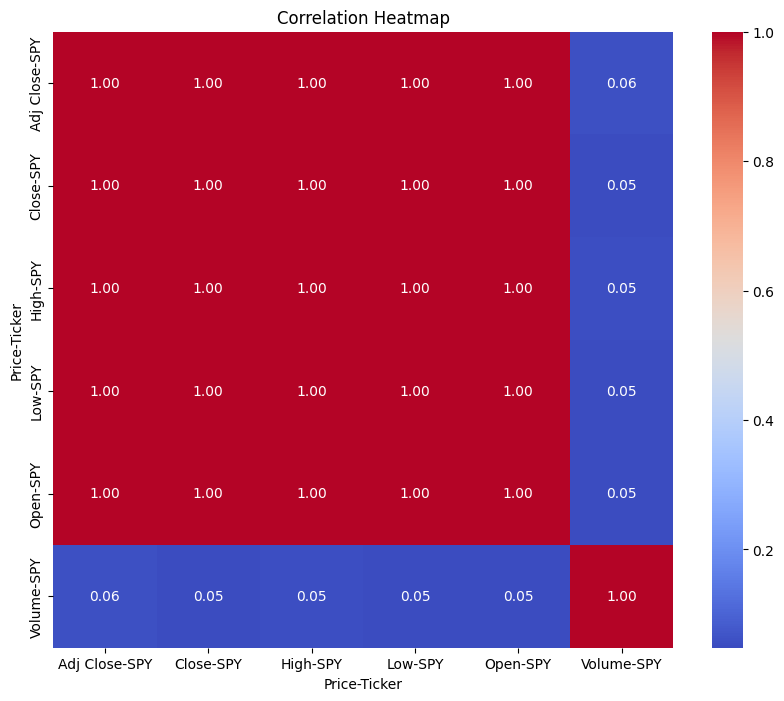

In [58]:
import seaborn as sns
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


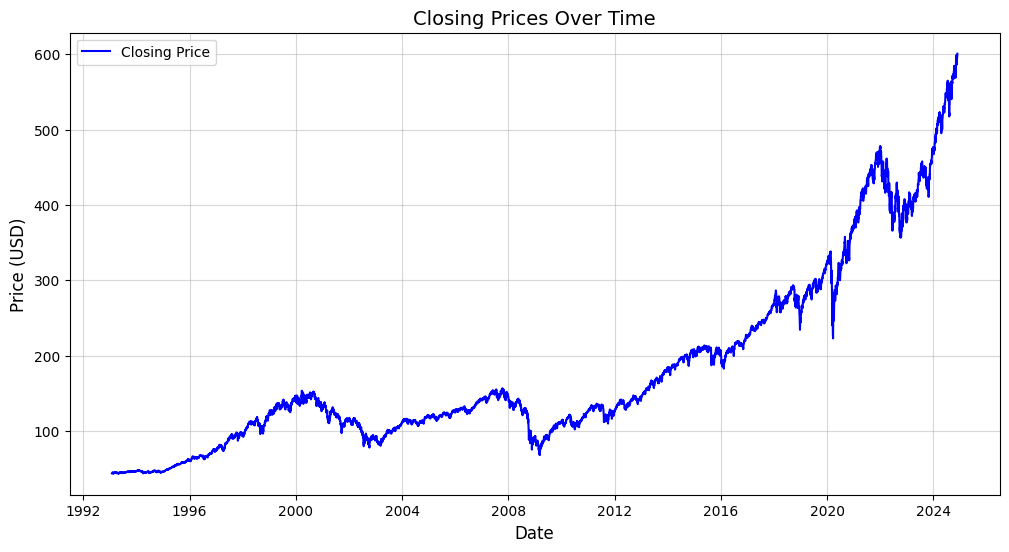

In [59]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price', color='blue', linewidth=1.5)
plt.title('Closing Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


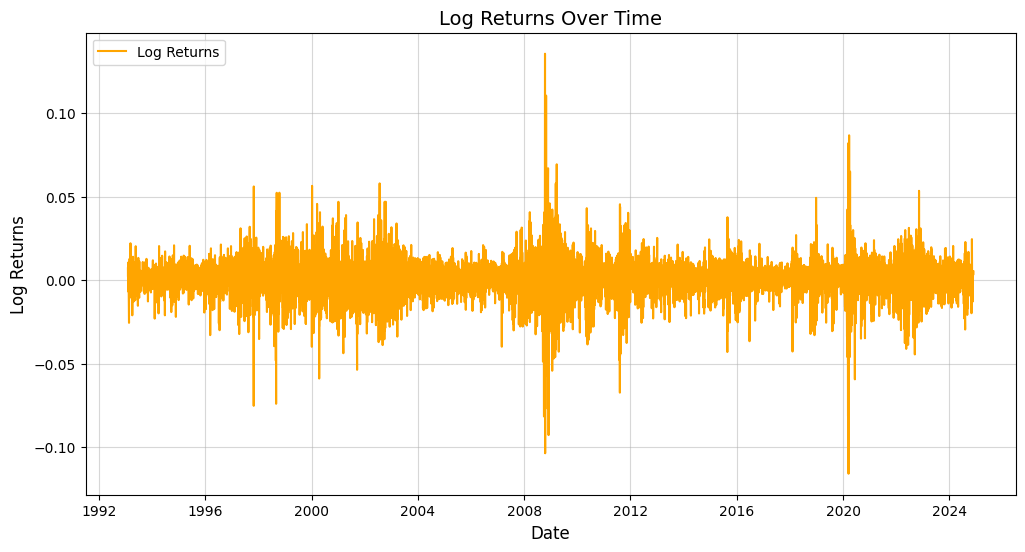

In [60]:
# Calculate log returns
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Plot log returns
plt.figure(figsize=(12, 6))
plt.plot(df['log_returns'], label='Log Returns', color='orange', linewidth=1.5)
plt.title('Log Returns Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()



### Difference Between Price and Return  

#### **Price**  
- **Definition**: The absolute value of an asset (e.g., stock or cryptocurrency) at a given time.  
- **Usage**: Used for trend analysis and market movement observation.  
- **Example**: Prices: $100, $102, $105.  

#### **Return**  
- **Definition**: The percentage change in price over a period, indicating growth or loss.   
- **Usage**: Used for performance analysis, risk management, and volatility measurement.  
- **Example**:  
  - Prices: $100 → $102 → $105.  
  - Returns: 2%, 2.9%.  

#### **Key Difference**  
| **Aspect**      | **Price**                     | **Return**               |
|------------------|-------------------------------|--------------------------|
| **Meaning**      | Asset’s value                | Percentage price change  |
| **Unit**         | Absolute (e.g., USD)         | Relative (%)             |
| **Analysis Use** | Market trends                | Risk & growth analysis   |

---  


# Data Preprocessing

### Calculating Realized Volatility  
Logarithmic returns and a rolling window are used to compute the 21-day realized volatility, providing insights into price fluctuations over time.  


In [61]:
df['log_close'] = np.log(df['Close'])

def get_realized_vol(dataset, time):
    dataset['returns'] = np.log(dataset["Close"] / dataset["Close"].shift(1))
    dataset.fillna(0, inplace=True)
    # Rolling window volatility
    volatility = dataset['returns'].rolling(window=time).std(ddof=0)
    return volatility

df['RV'] = get_realized_vol(df, 21)

df['RV']

,RV
Date,
1993-01-29 00:00:00+00:00,NaN
1993-02-01 00:00:00+00:00,NaN
1993-02-02 00:00:00+00:00,NaN
1993-02-03 00:00:00+00:00,NaN
1993-02-04 00:00:00+00:00,NaN
...,...
2024-11-20 00:00:00+00:00,0.008707
2024-11-21 00:00:00+00:00,0.008478
2024-11-22 00:00:00+00:00,0.008485


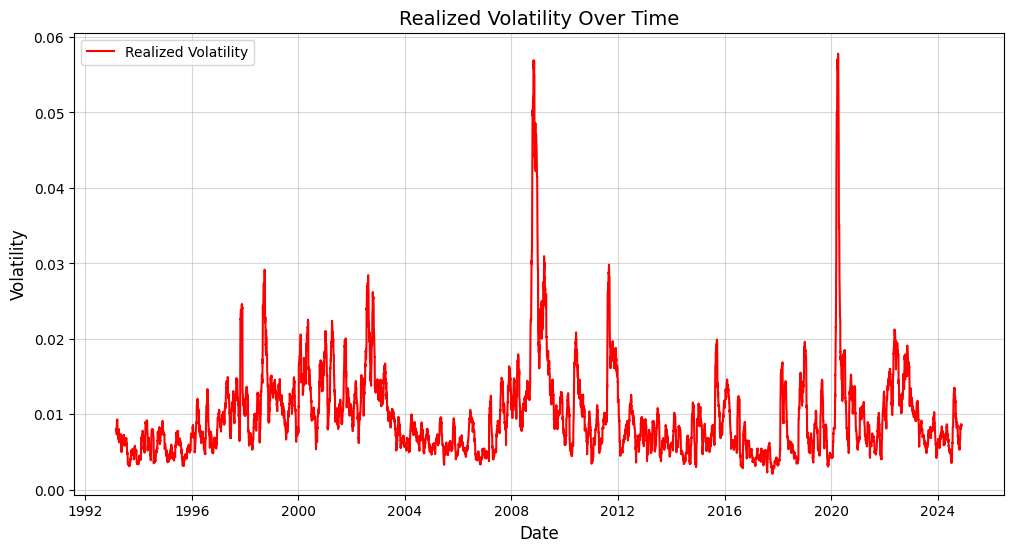

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(df['RV'], label='Realized Volatility', color='red', linewidth=1.5)
plt.title('Realized Volatility Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

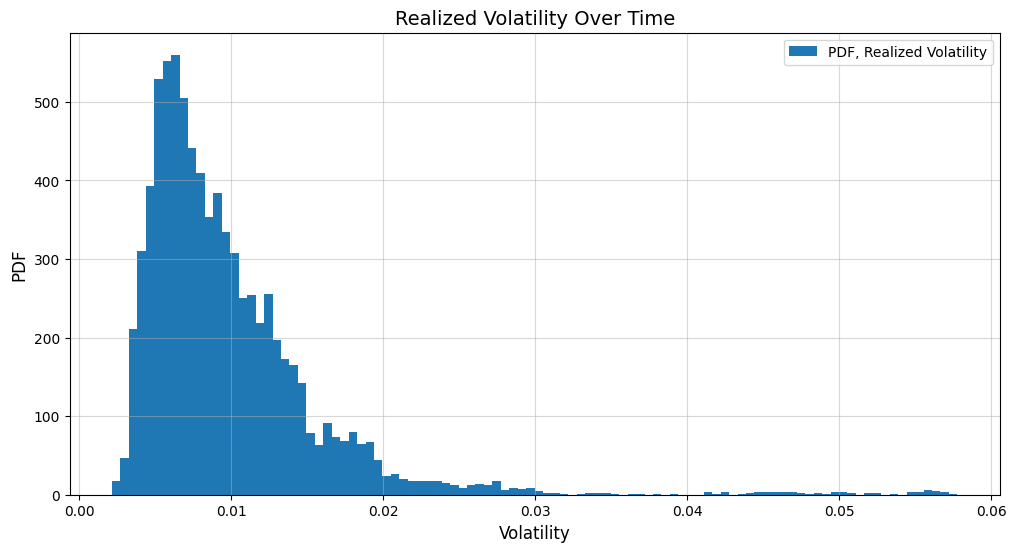

In [63]:
plt.figure(figsize=(12, 6))
plt.hist(df['RV'], 100, label='PDF, Realized Volatility')
plt.title('Realized Volatility Over Time', fontsize=14)
plt.ylabel('PDF', fontsize=12)
plt.xlabel('Volatility', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.5)
plt.show()

In [34]:
rv_stats = df['RV'].describe()
skewness = df['RV'].skew()
kurtosis = df['RV'].kurt()

print(rv_stats)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")


count    7995.000000
mean        0.009807
std         0.006123
min         0.002135
25%         0.005969
50%         0.008293
75%         0.011957
max         0.057785
Name: RV, dtype: float64
Skewness: 3.1770904128212387
Kurtosis: 16.59122089654542


### Preprocessing Realized Volatility  
The realized volatility data is scaled to a range of [0,1] for efficient model training, and 80% is allocated for training.  


In [ ]:
# Step 3: Preprocess data
dataset = df['RV'].dropna().values.reshape(-1, 1)

import math

training_data_len = math.ceil(len(dataset)*.8)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.09586729],
       [0.10661656],
       [0.10517594],
       ...,
       [0.11398096],
       [0.11410638],
       [0.11409566]])

In [ ]:
train_data = scaled_data[0:training_data_len,:]


x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.09586729, 0.10661656, 0.10517594, 0.10719114, 0.10202192,
       0.12519485, 0.12590588, 0.12596756, 0.12368879, 0.12932579,
       0.12930923, 0.12616877, 0.09164618, 0.09238869, 0.09581098,
       0.09842973, 0.09816882, 0.0980385 , 0.09169361, 0.09394099,
       0.09461933, 0.09404317, 0.08209423, 0.0818336 , 0.10500937,
       0.10643937, 0.07462858, 0.07607931, 0.0752721 , 0.08961901,
       0.08391898, 0.08236445, 0.08236445, 0.08007031, 0.07820516,
       0.07732736, 0.07555588, 0.08452356, 0.08507405, 0.08379004,
       0.09190621, 0.09020545, 0.09108306, 0.09149608, 0.0943195 ,
       0.06711957, 0.06601312, 0.06636098, 0.06588393, 0.06602249,
       0.05179678, 0.0513651 , 0.06163162, 0.0615626 , 0.06302028,
       0.06212502, 0.0886691 , 0.08884583, 0.08354183, 0.08233943])]
[0.0765946120103206]



# Split data to train and test

In [ ]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(6336, 60, 1)

# DNN Model

### Model Architecture Design  
A fully connected deep neural network (DNN) with multiple layers is implemented. The architecture includes dropout for regularization, batch normalization to improve training stability, and ReLU activation functions. The model is compiled with the Adam optimizer and mean squared error as the loss function for regression tasks.  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



# Step 2: Redesign the model architecture
def create_optimized_model():
    model = Sequential()

    # Input Layer + Batch Normalization
    model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    # Hidden Layer 1
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 2
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))


    # Hidden Layer 3
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())


    # Output Layer for regression (single neuron for continuous output)
    model.add(Dense(1))

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Step 3: Create the model
model = create_optimized_model()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 4: Add callbacks
# - ReduceLROnPlateau: Reduces the learning rate when a plateau in loss is detected.
# - EarlyStopping: Stops training if the validation loss doesn't improve after a few epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Step 6: Evaluate the model
results = model.evaluate(x_train, y_train)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 1.4880 - mae: 0.9149 - val_loss: 0.0122 - val_mae: 0.1013 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4894 - mae: 0.5243 - val_loss: 0.0028 - val_mae: 0.0458 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2743 - mae: 0.3889 - val_loss: 0.0035 - val_mae: 0.0527 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1696 - mae: 0.3086 - val_loss: 0.0022 - val_mae: 0.0337 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1311 - mae: 0.2619 - val_loss: 0.0046 - val_mae: 0.0539 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0907 - mae: 0.2257 - val_loss: 0.0059 - val_mae: 0.0605 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0681 - mae: 0.1954 - val_loss: 0.0043 - val_mae: 0.0490 - learning_rate: 0.0010
Epoch 

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 629,893 (2.40 MB)

 Trainable params: 209,217 (817.25 KB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 418,436 (1.60 MB)

### Visualizing Training Progress  
Two visualization functions are provided to monitor the training process of the model:  

1. **Loss Over Epochs:** Plots the training and validation loss (Mean Squared Error) to assess convergence and overfitting trends.  
2. **Mean Absolute Error (MAE) Over Epochs:** Tracks training and validation MAE to evaluate the model's predictive accuracy during training.  

These plots provide insight into the model's performance and help fine-tune hyperparameters for better results.


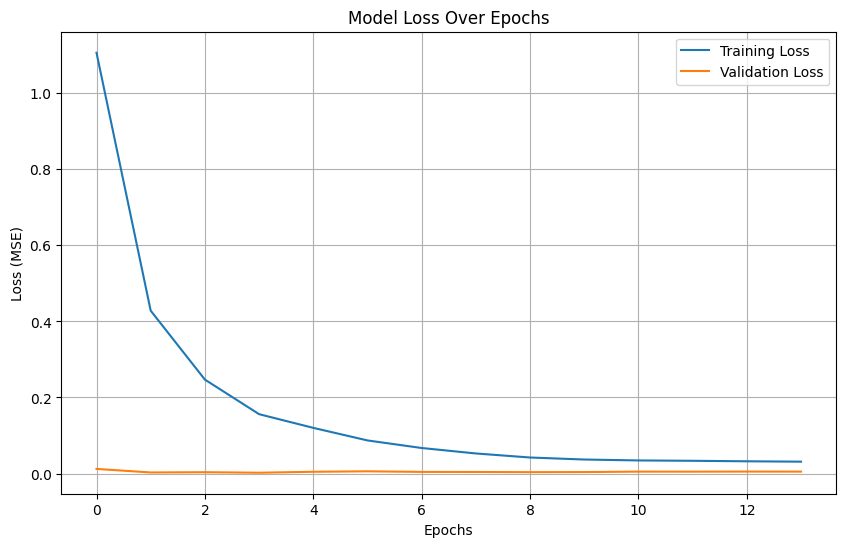

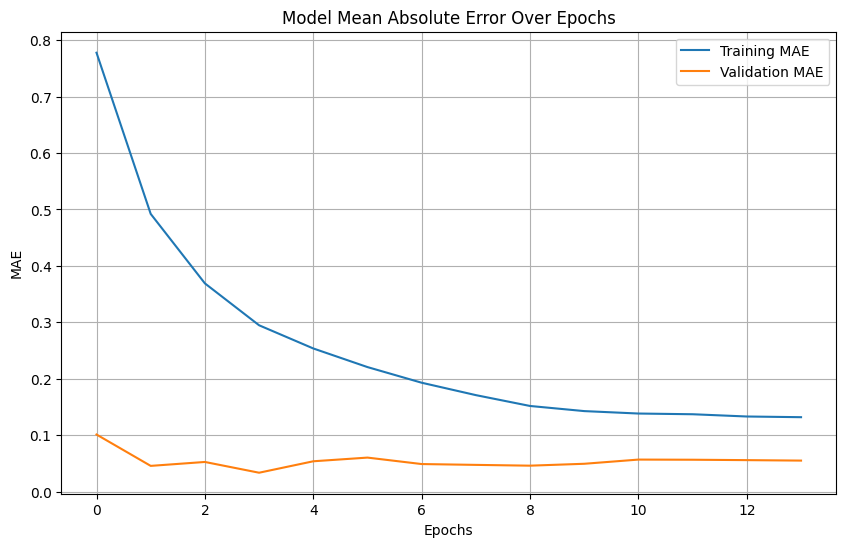

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss over epochs
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Mean Absolute Error over epochs
def plot_mae(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting functions
plot_loss(history)
plot_mae(history)


In [ ]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])



x_test=np.array(x_test)
# Reshape the data to 3D
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


### Making Predictions and Rescaling  
1. **Predicting Values:** The model makes predictions on the test data using `model.predict(x_test)`.
2. **Reshaping Predictions:** The predicted values are reshaped to match the expected dimensions using `predictions.reshape(predictions.shape[0], -1)`.
3. **Inverse Scaling:** The predictions are transformed back to their original scale using `scaler.inverse_transform(predictions)`, which restores the values to their original range (e.g., actual price values).

This process ensures that the predicted values are in the correct format and scale for comparison to actual values.


In [ ]:

predictions=model.predict(x_test)
predictions = predictions.reshape(predictions.shape[0], -1)  # Reshape to (1591, 60)
predictions = scaler.inverse_transform(predictions)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


# Mdel evaluation

### Evaluating Model Performance  
1. **Metrics Calculation:**  
   - **MAE:** Mean Absolute Error, calculated using `mean_absolute_error`.
   - **RMSE:** Root Mean Squared Error, calculated using `np.sqrt(mean_squared_error)`.
   - **MAPE:** Mean Absolute Percentage Error, calculated with `mean_absolute_percentage_error`.
   - **R²:** R-squared, calculated using `r2_score`.
   - **RMSPE:** Root Mean Squared Percentage Error, implemented with a custom function `rmspe` to evaluate prediction accuracy.

2. **Result Printing:**  
   - The model's performance metrics are displayed, including **RMSPE**, **MAE**, **RMSE**, **MAPE**, and **R²**, to assess how well the model performs on the test data.

These metrics provide insights into prediction accuracy, error magnitude, and the goodness of fit.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

actual_value = dataset[training_data_len: , : ]


def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


# Step 3: Calculate metrics for the test set
mae_test = mean_absolute_error(actual_value, predictions)
rmse_test = np.sqrt(mean_squared_error(actual_value, predictions))
mape_test = mean_absolute_percentage_error(actual_value, predictions)
r2 = r2_score(actual_value, predictions)

rmspe_value = rmspe(actual_value, predictions)

# Print the RMSPE result
print(f"RMSPE: {rmspe_value}")

# Print the metrics
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test r2: {r2}")


RMSPE: 0.37568728961221776
Test MAE: 0.0033339976870058233
Test RMSE: 0.006663744205485747
Test MAPE: 0.2846586089914939
Test r2: 0.04334309479793319


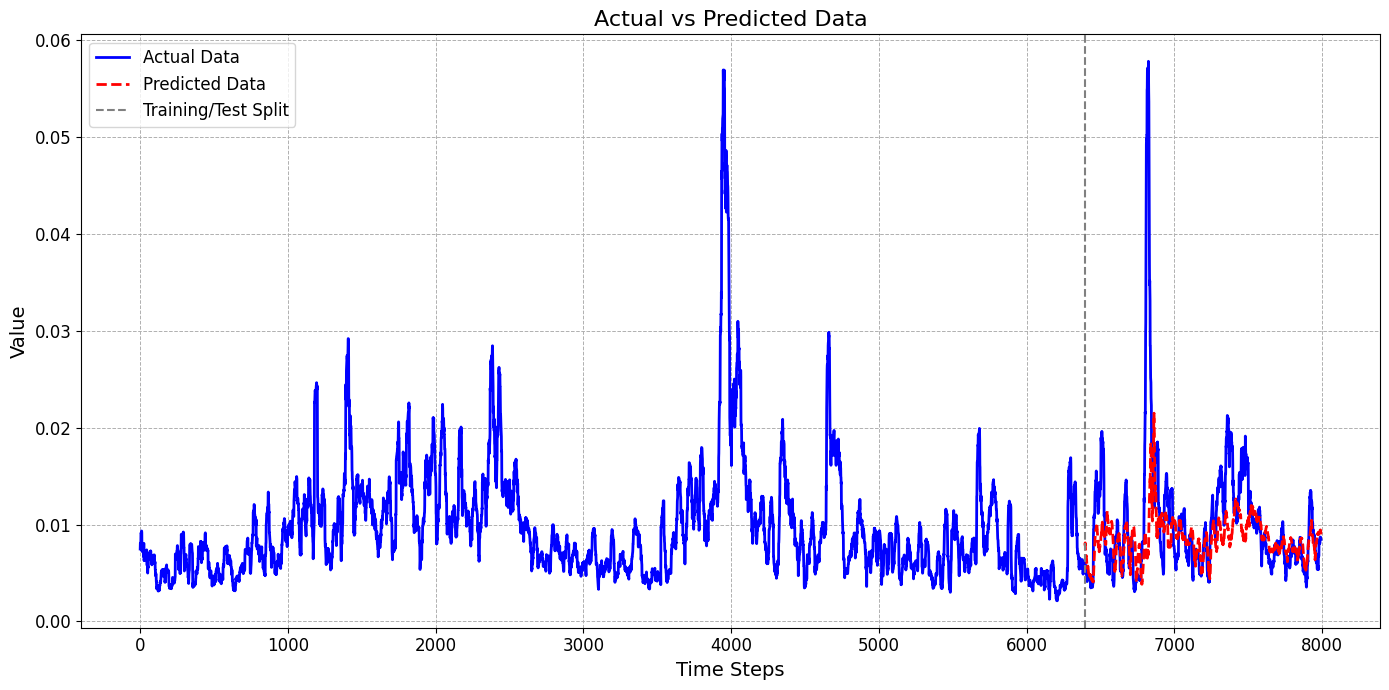

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test contains the actual data in the original scale
# Assuming predictions contains the predicted data in the original scale
# Assuming dataset contains all actual values including training and testing

# Create a figure with specified size
plt.figure(figsize=(14, 7))

# Plot actual data
plt.plot(np.arange(len(dataset)), dataset, label='Actual Data', color='blue', linewidth=2)

# Plot predicted data
plt.plot(np.arange(training_data_len, len(dataset)), predictions, color='red', linewidth=2, linestyle='--', label='Predicted Data')

# Highlighting the training and testing data separation
plt.axvline(x=training_data_len, color='gray', linestyle='--', label='Training/Test Split')

# Add labels and title
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Actual vs Predicted Data', fontsize=16)

# Show legend with a specific location
plt.legend(loc='upper left', fontsize=12)

# Adding grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Set x and y ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping


# Save the plot to a file
plt.savefig('pre_plot.png', dpi=300)  # Higher DPI for better quality

# Optionally, display the plot
plt.show()


# GARCH Model for Volatility Forecasting

The **Generalized Autoregressive Conditional Heteroskedasticity (GARCH)** model is widely used in finance to model and forecast time-varying volatility. Volatility, a statistical measure of the dispersion of returns, is a crucial factor in risk management, asset pricing, and portfolio optimization.

## Key Concepts of GARCH:
- **Autoregressive (AR)**: The model uses past values of volatility to predict future volatility.
- **Conditional Heteroskedasticity**: This term indicates that the variance (volatility) of the error term is not constant over time but depends on past errors.

The GARCH model allows for volatility clustering, a phenomenon where periods of high volatility tend to follow high volatility and low volatility follows low volatility. This is particularly important for financial markets, where volatility exhibits time-varying patterns.



In [51]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.9 MB/s eta 0:00:00


In [66]:
# Import necessary libraries
import pandas as pd
from arch import arch_model

# Check for NaN or infinite values in 'RV' column
print("NaN values in 'RV':", df['RV'].isna().sum())
print("Infinite values in 'RV':", (df['RV'] == float('inf')).sum())

# Clean the data by replacing NaN and infinite values with 0
df['RV'] = df['RV'].replace([float('inf'), -float('inf')], 0)  # Replace infinite values with 0
df['RV'] = df['RV'].fillna(0)  # Replace NaN values with 0

# Verify that there are no NaN or infinite values
print("NaN values after cleaning:", df['RV'].isna().sum())
print("Infinite values after cleaning:", (df['RV'] == float('inf')).sum())

# Fit the GARCH(1,1) model
garch_model = arch_model(df['RV'], vol='Garch', p=1, q=1)
garch_results = garch_model.fit()

# View the results
print(garch_results.summary())


NaN values in 'RV': 20
Infinite values in 'RV': 0
NaN values after cleaning: 0
Infinite values after cleaning: 0
Iteration:      1,   Func. Count:      5,   Neg. LLF: -34038.87645450313
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -34038.87655221798
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                     RV   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                34038.9
Distribution:                  Normal   AIC:                          -68069.8
Method:            Maximum Likelihood   BIC:                          -68041.8
                                        No. Observations:                 8015
Date:                Wed, Nov 27 2024   Df Residuals:  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.763e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




Based on the output of the GARCH model and the performance of the DNN model, here's a comparison between the two models for volatility prediction:

### GARCH Model Summary:
- **Log-Likelihood**: -34038.88
- **AIC (Akaike Information Criterion)**: -68069.8
- **BIC (Bayesian Information Criterion)**: -68041.8
- **R-squared**: 0.000 (indicating that the mean model doesn't explain much of the variance in the data)
- **Volatility Coefficients**:
  - **Alpha[1] (ARCH term)**: 0.2000 (significant, indicating that past squared errors influence current volatility)
  - **Beta[1] (GARCH term)**: 0.7800 (high, indicating that past volatility has a strong impact on current volatility)
  - **Omega**: 7.5266e-07 (a very small constant)

### DNN Model Performance:
- **RMSPE (Root Mean Squared Percentage Error)**: 0.3757
- **Test MAE (Mean Absolute Error)**: 0.0033
- **Test RMSE (Root Mean Squared Error)**: 0.0067
- **Test MAPE (Mean Absolute Percentage Error)**: 0.2847
- **Test R²**: 0.0433 (indicating a very low explanation of variance)

### Key Observations:
- **GARCH Model**: This model is designed specifically for time-varying volatility and captures volatility clustering well, as shown by the significant coefficients for the ARCH (α) and GARCH (β) terms. However, the R-squared value for the mean model is 0.000, meaning that the model's mean component doesn't explain the variance in the data well. The GARCH model focuses more on volatility modeling than on explaining returns or price movements directly.
  
- **DNN Model**: This model shows relatively better prediction metrics (with test MAE of 0.0033 and RMSE of 0.0067). However, the R² value of 0.0433 suggests that the model is not explaining much of the variability in the test data. RMSPE of 0.3757 and MAPE of 0.2847 indicate a moderate fit, but it could likely benefit from further optimization or feature engineering.

### Conclusion:
- The **GARCH model** excels in modeling volatility and capturing the autoregressive nature of volatility over time but does not explain much of the overall data variability. It is well-suited for applications that focus on modeling and forecasting volatility.
  
- The **DNN model** provides better overall error metrics for prediction but still has room for improvement. The low R² indicates that the model isn't fully capturing the patterns in the data, which suggests that further tuning, feature selection, or a hybrid approach might be beneficial for improving performance.

In summary, both models have their strengths: GARCH for volatility modeling and DNN for more general forecasting tasks. Depending on your specific use case (e.g., forecasting volatility vs. price prediction), one model might be more appropriate than the other.